<font face="Times New Roman" size=5>
<div dir=rtl align="center">

<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Introduction to Machine Learning
</font>

<hr/>
<font color="#80a080" size=5>
Assignment 3: Linear Regression  
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2025
<br>
</font>
<hr>
</div></font>

> - Full Name: **[MohammadMobinJelodar]**
> - Student ID: **[402101493]**

# Part 1: Linear regression

In this part you will implement a linear regression and train it using just the gradient descent and numpy.

In [22]:
import numpy as np
import pandas as pd

Load the data

In [23]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import http
import io
import requests

url = 'https://raw.githubusercontent.com/HSE-LaMBDA/MLatURL2019/master/day2/house-train.csv'
try:
    data = pd.read_csv(url)
except http.client.IncompleteRead as e:
    r = requests.get(url, timeout=10)
    b = io.StringIO(r.text)
    data = pd.read_csv(b)

Inspect the data

In [24]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Univariate linear regression using an analytic solution

In this section, you will program the univariate least squares linear regression from scratch using an analytic formulae.

Recall, that we're working with a problem of finding a weight $w$ such that
$$
\sum_i (y_i - w \cdot x_i)^2 \to \min,
$$
with $x_i, y_i \in R^1$, i.e. they are numbers.

Recall that our least squares solution is of the form:
$$
\widehat{w}_1 =
    \frac{\sum_{i=1}^{\ell} (x_i - \mu_x) (y_i - \mu_y)}
        {\sum_{i=1}^{\ell} (x_i - \mu_x)^2}, \\
\widehat{w}_0 = \mu_y - \widehat{w}_1 \mu_x
$$
with $\mu_x = \frac{1}{\ell} \sum_{i=1}^{\ell} x_i,
\quad
\mu_y = \frac{1}{\ell} \sum_{i=1}^{\ell} y_i$

In [25]:
def compute_weights_univariate(X, y):
    """
    Given feature array X [n_samples], target vector y [n_samples],
    compute the optimal least squares solution using the formulae above.
    """
    x = np.asarray(X).astype(float)
    yy = np.asarray(y).astype(float)
    mu_x = x.mean()
    mu_y = yy.mean()
    num = np.sum((x - mu_x) * (yy - mu_y))
    den = np.sum((x - mu_x) ** 2)
    w_1 = num / den
    w_0 = mu_y - w_1 * mu_x
    return np.array([w_0, w_1])

In [26]:
X = data['GrLivArea']
y = data['SalePrice']

w = compute_weights_univariate(X, y)
w

array([18569.02585649,   107.13035897])

**How precise are we?**

We commonly evaluate predictions using MSE errors. These are defined as:
$$
MSE(y, \widehat{y}) = \frac 1 \ell \sum_i (y_i - w^T x_i)^2
$$
as implemented either by `sklearn.metrics.mean_squared_error` or simply by `np.mean((y - y_pred) ** 2)`.

We then use $\sqrt{MSE(y, \widehat{y})}$ to obtain numbers in the same dimensionality (units, not units squared).

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
w_0, w_1 = w
np.sqrt(
    mean_squared_error(y, np.dot(X, w_1) + w_0)
)

np.float64(56034.303865279944)

### Multivariate linear regression using an analytic solution

In this section, you will program the **multi**variate least squares linear regression from scratch using an analytic formulae.

Recall, that we're working with a problem of finding a weight $w$ such that
$$
||\mathbf{y} - \mathbf{X} \mathbf{w}|| \to \min_{\mathbf{w}},
$$
with $\mathbf{x}_i \in R^n$, i.e. features are no longer supposed to be single numbers, but vectors of numbers (but still $y_i \in R^1$).

Recall that our least squares solution is of the form:
$$
\mathbf{w} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}.
$$

We could account for the non-zero mean case ($\mathrm{E} \mathbf{y} \neq 0$) by either adding and subtracting the mean, or by using an additional feature in $\mathbf{X}$ set to all ones.

In [29]:
def prepare_features(X):
    """
    Given feature array X [n_samples, n_features], preprocess it by
    standardizing and appending a column of 1s.
    """
    arr = np.asarray(X).astype(float)
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    mean = arr.mean(axis=0)
    std = arr.std(axis=0)
    std[std == 0] = 1.0
    X_std = (arr - mean) / std
    ones = np.ones((X_std.shape[0], 1))
    return np.hstack([ones, X_std])

In [30]:
def compute_weights_multivariate(X, y):
    """
    Given feature array X [n_samples, 1], target vector y [n_samples],
    compute the optimal least squares solution using the formulae above.
    Don't forget the bias term!
    """
    X_proc = prepare_features(X)
    y_arr = np.asarray(y).astype(float).reshape(-1, 1)
    XtX = X_proc.T.dot(X_proc)
    XtX_inv = np.linalg.pinv(XtX)
    XtY = X_proc.T.dot(y_arr)
    w = XtX_inv.dot(XtY).flatten()
    return w

In [31]:
X = data['GrLivArea']
X = np.atleast_2d(X).T
y = data['SalePrice']

w = compute_weights_multivariate(X, y)
w

array([180921.19589041,  56275.61972722])

In [32]:
# note that we must run prepare_features(X) here, too, to obtain the exact same
# feature representation of the input
np.sqrt(
    mean_squared_error(y, np.dot(prepare_features(X), w))
)

np.float64(56034.303865279944)

### Multivariante linear regression using the Gradient Descent

To use the gradient descent, we must
* initialize the weights $\mathbf{w}$ somehow,
* find a way of computing the __gradient__ of our quality measure $L(\mathbf{y}, \widehat{\mathbf{y}})$ w.r.t. $\mathbf{w}$,
* starting from the initialization, iteratively update weights using the gradient descent:
$$
\mathbf{w}^{(i+1)} \leftarrow \mathbf{w}^{(i)} - \gamma \nabla_{\mathbf{w}} L
$$

Since we choose $L(\mathbf{y}, \widehat{\mathbf{y}}) \equiv \frac 1 \ell ||\mathbf{y} - \mathbf{X} \mathbf{w} ||^2$, our gradient is $ \frac 2 \ell (\mathbf{y} - \mathbf{X} \mathbf{w}) \mathbf{X} $

In [33]:
def compute_gradient(X, y, w):
    """
    Computes the gradient of MSE loss
    for multivariate linear regression of X onto y
    w.r.t. w, evaluated at the current w.
    """
    X_arr = np.asarray(X).astype(float)
    if X_arr.ndim == 1:
        X_arr = X_arr.reshape(-1, 1)
    y_arr = np.asarray(y).astype(float).reshape(-1, 1)
    w_arr = np.asarray(w).astype(float).reshape(-1, 1)
    n = X_arr.shape[0]
    preds = X_arr.dot(w_arr)
    residuals = preds - y_arr
    grad = (2.0 / n) * (X_arr.T.dot(residuals)).flatten()
    return grad

In [34]:
def gradient_descent(X, y, w_init, iterations=1, gamma=0.01):
    """
    Performs the required number of iterations of gradient descent.
    Parameters:
        X [n_objects, n_features]: matrix of featues
        y [n_objects]: responce (dependent) variable
        w_init: the value of w used as an initializer
        iterations: number of steps for gradient descent to compute
        gamma: learning rate (gradient multiplier)
    """
    costs, ws = [], []
    w = np.asarray(w_init).astype(float).copy()
    X_proc = np.asarray(X).astype(float)
    for i in range(iterations):
        preds = X_proc.dot(w)
        residuals = preds - np.asarray(y).astype(float)
        cost = np.mean(residuals ** 2)
        costs.append(cost)
        ws.append(w.copy())
        grad = compute_gradient(X_proc, y, w)
        w = w - gamma * grad
    return costs, ws

Now run the gradient descent to find the optimal weights vector.

In [35]:
X = data['GrLivArea']
X = np.atleast_2d(X).T
X = prepare_features(X)
y = data['SalePrice']

gamma = 0.01  # Step size
iterations = 200  # No. of iterations
np.random.seed(123)  # Set the seed
w_init = np.random.rand(X.shape[1]) #Pick some random values to start with

# Pass the relevant variables to the function and get the new values back...
costs, ws = gradient_descent(X, y, w_init, iterations, gamma)
w = ws[-1]

# Print the results...
print("Gradient Descent: {:.2f}, {:.2f}".format(w[0], w[1]))

Gradient Descent: 177674.24, 55265.65


The following 3 code cells display the cost function and its progress as the learning continues.

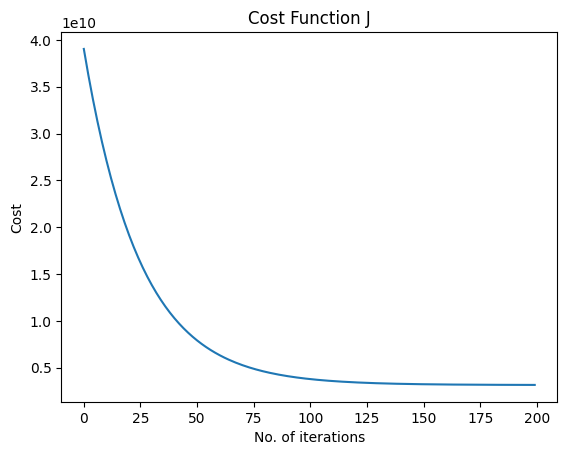

In [36]:
#Plot the cost function...
plt.title('Cost Function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(costs)
plt.show()

In [37]:
#Animation
def animate_to_gif(X, y, costs, out_filename='animation.gif'):

    fig = plt.figure()
    ax = plt.axes()
    plt.title('Sale Price vs Living Area')
    plt.xlabel('Living Area in square feet (normalised)')
    plt.ylabel('Sale Price ($)')
    plt.scatter(X[:,1], y, color='red')
    line, = ax.plot([], [], lw=2)
    annotation = ax.text(-1, 700000, '')
    annotation.set_animated(True)
    plt.close()

    #Generate the animation data,
    def init():
        line.set_data([], [])
        annotation.set_text('')
        return line, annotation

    # animation function.  This is called sequentially
    def animate(i):
        x = np.linspace(-5, 20, 1000)
        y = ws[i][1]*x + ws[i][0]
        line.set_data(x, y)
        # annotation.set_text('Cost = %.2f e10' % (past_costs[i]/10000000000))
        return line, annotation

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=iterations, interval=0, blit=True)

    anim.save(out_filename, writer='pillow', fps = 30)


def animation_display(filename='animation.gif'):
    #Display the animation...
    import io
    import base64
    from IPython.display import HTML

    video = io.open(filename, 'r+b').read()
    encoded = base64.b64encode(video)
    HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))


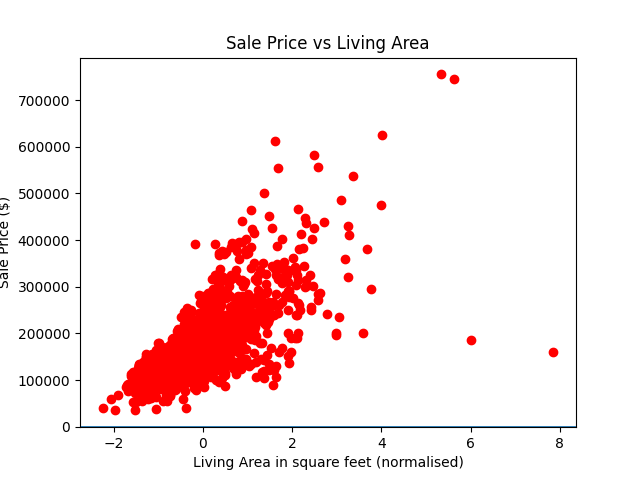

In [38]:
out_filename = 'animation_gd.gif'

animate_to_gif(X, y, costs, out_filename)

#Display the animation...
import io
import base64
from IPython.display import HTML

video = io.open(out_filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

# Part 2: Logistic Regression

# Logistic Regression

Given $x$, we want to find the **probability** that $x$ belongs to class $1$: $$\hat{y}=\mathbb{P}(y=1|x).$$

In **linear regression**, we would use $\hat{y}=w^{T}x+b$ (this is the equation of a **line** in higher dimensions), where $w \in \mathbb{R}^{n}$ are the weights/slope and $b \in \mathbb{R}$ is the bias/intercept. The problem here is that this can output **negative** values or values that are **bigger than 1**, which doesn't make sense for probabilities.

The solution is to apply a function that forces the output to be **between 0 and 1**. The function that everyone uses (because it has a nice gradient as we'll see later) is the **sigmoid function**:

$$\sigma(z)=\frac{1}{1+e^{-z}}.$$

Our model therefore becomes

$$\hat{y}=\sigma(w^{T}x+b).$$

The idea is that anything to the left of the red line ($\hat{y} < 0.5$) is **classified as 0** and anything to the right ($\hat{y} > 0.5$) is **classified as 1**. Our task is to learn the **optimal parameters** $w$ and $b$ so that the model can accurately predict the target.

Luckily, a convex cost function for logistic regression exists. This is the **cross-entropy loss**:

$$\mathcal{L}(\hat{y}, y)= -y \log(\hat{y})-(1-y) \log(1-\hat{y}).$$

We will show where this comes from soon but for now observe that $\mathcal{L}(\hat{y}, 1)=-\log(\hat{y})$, which is **small** when $\hat{y}$ is **close to 1** and large otherwise and $\mathcal{L}(\hat{y}, 0)=-\log(1-\hat{y})$, which is **small** when $\hat{y}$ is **close to 0** and large otherwise.

# Cost function

The loss function we defined above works for a single training example. Now we need to **extend** it to the **whole training set**. The way we do this is by taking the **average**.

$$J(w,b)=\frac{1}{m} \sum_{i=1}^{m} \mathcal{L}(\hat{y}^{(i)},y^{(i)})$$

The reason we devide by $m$ is so that if we change the size of the training set then we can still **compare** the cost function in a **fair** way.

# Gradient descent

We now turn to optimising the cost function. The **simplest** algorithm that does this (other than guessing randomly) is gradient descent. The idea is to repeatedly take **small steps** in the **direction of steepest descent**, where this direction is given by the **gradient**. The update rules for the k-th iteration are given by

$$w_{k+1}=w_{k}-\alpha \frac{\partial J}{\partial w} \biggr\rvert_{(w_k,b_k)}, \qquad b_{k+1}=b_{k}-\alpha \frac{\partial J}{\partial b} \biggr\rvert_{(w_k,b_k)}$$

where $\alpha$ is the **learning rate**, i.e. how big the steps are. If $\alpha$ is too small then the algorithm will take a long time to converge but if $\alpha$ is too big then it might keep jumping over the minimum and struggle to converge; the right value is somewhere in between.

**Computation graph**

Now let's express logistic regression as a **computation graph** (which simply expresses a function as a sequence of simpler functions on a graph); this will make computing the derivatives easier.

[![IMG-0010.jpg](https://i.postimg.cc/wTtft6QM/Screenshot-from-2025-11-22-12-46-28.png)](https://i.postimg.cc/wTtft6QM/Screenshot-from-2025-11-22-12-46-28.png)



To work out the **output** of these functions we go **forward** on this graph. To work out their **derivatives** we go **backwards** and multiply their individual derivatives together. In particular,

$$\frac{d\mathcal{L}}{dw}=\frac{d\mathcal{L}}{da} \frac{da}{dz} \frac{dz}{dw}, \qquad \frac{d\mathcal{L}}{db}=\frac{d\mathcal{L}}{da} \frac{da}{dz} \frac{dz}{db}.$$

So we just need to work out the following 4 derivatives:

$$\frac{d\mathcal{L}}{da}, \quad \frac{da}{dz}, \quad \frac{dz}{dw}, \quad \frac{dz}{db}.$$

**Derivatives**

1. Recall $\mathcal{L}(a,y)=-y \log(a) - (1-y) \log(1-a)$, so using that the derivative of $\log(a)$ is $\frac{1}{a}$, we get


$$
\begin{aligned}
\frac{d\mathcal{L}}{da}&=-y \times \frac{1}{a}-(1-y) \times \frac{1}{1-a} \times (-1) \\
 &=-\frac{y}{a}+\frac{1-y}{1-a}
\end{aligned}
$$

2. Recall $a=\sigma(z)=(1+e^{-z})^{-1}$, so by the chain rule we have

$$\begin{align}
\frac{da}{dz}&=-(1+e^{-z})^{2} \times (-e^{-z}) \\
&=\frac{1}{1+e^{-z}} \times \frac{e^{-z}}{1+e^{-z}} \\
&=a(1-a)
\end{align}$$

3. Recall $z=\sum_{i=1}^{n} w_i x_i +b$, so by linearity of differentiation we have

$$\frac{dz}{dw}= x$$

4. Finally,

$$\frac{dz}{db}=1$$

**Putting the pieces together**

We've done the hard part. Now we just need to **multiply** the correct derivatives together.

$$ \begin{align}
\frac{d\mathcal{L}}{dw}&=\frac{d\mathcal{L}}{da} \frac{da}{dz} \frac{dz}{dw} \\
&= \left(-\frac{y}{a}+\frac{1-y}{1-a} \right) \times a(1-a) \times x \\
&= (a-y)x
\end{align}$$

$$ \begin{align}
\frac{d\mathcal{L}}{db}&=\frac{d\mathcal{L}}{da} \frac{da}{dz} \frac{dz}{db} \\
&= \left(-\frac{y}{a}+\frac{1-y}{1-a} \right) \times a(1-a) \times 1 \\
&= (a-y)
\end{align}$$

Hence the **derivatives** of the cost function $J(a,y)=\frac{1}{m}\sum_{i=1}^{m}\mathcal{L}(a^{(i)},y^{(i)})$ are just

$$\begin{align}
\frac{dJ}{dw}&=\frac{1}{m} \sum_{i=1}^{k} \frac{d\mathcal{L(a^{(i)},y^{(i)})}}{dw} \\
&=\frac{1}{m} \sum_{i=1}^{k} (a^{(i)}-y^{(i)})x^{(i)} \\
\end{align}$$

and

$$\begin{align}
\frac{dJ}{db}&=\frac{1}{m} \sum_{i=1}^{k} \frac{d\mathcal{L(a^{(i)},y^{(i)})}}{db} \\
&=\frac{1}{m} \sum_{i=1}^{k} (a^{(i)}-y^{(i)}) \\
\end{align}.$$

**Pseudo-code (vectorised)**

Vectorisation **avoids for loops** and instead utilises CPU/GPU paralelisation which is often **significantly faster**. The idea is to use built in matrix algebra functions instead of using a for loop. Let's define some matrices that we'll use

$$Z=[z^{(1)}, ..., z^{(m)}], \quad \text{where} \quad z^{(i)}=w^{T}x^{(i)}+b,$$

$$A=[a^{(1)}, ..., a^{(m)}], \quad \text{where} \quad a^{(i)}=\sigma(z^{(i)}),$$

$$dZ=[dz^{(1)}, ..., dz^{(m)}], \quad \text{where} \quad dz^{(i)}=a^{(i)}-y^{(i)},$$

Now observe that we can quickly compute these via $Z=w^{T}X+b$, $A=\text{sigmoid}(Z)$ and $dZ=A-Y$. Also, the derivatives are also nice: $db=dZ.\text{sum}()/m$ and $dw=(X @ dZ^T)/m$.

```
Inputs: X, Y, alpha, K
Initialise w=np.zeros(len(X)), b=0
    For k=1, ..., K:
        Z=w.T@X+b
        A=sigmoid(Z)
        
        # Cost function
        J=-(np.dot(Y,np.log(A))+np.dot(1-Y,np.log(1-A)))/m
        
        # Derivatives
        dZ=A-Y
        dw=(X@dZ.T)/m
        db=dZ.sum()/m
        
        # Gradient descent step
        w=w-alpha*dw
        b=b-alpha*db
        
        print(J)
        
    return w, b
```

# Code from scratch

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

In [40]:
class Logistic_Regression:
    def __init__(self, alpha, K):
        self.alpha = alpha
        self.K = K
        self.costs = np.zeros((K), dtype=float)
        self.w = None
        self.b = 0.0

    def fit(self, X, y):
        X_arr = np.asarray(X).astype(float)
        y_arr = np.asarray(y).astype(float)
        m, n = X_arr.shape
        self.w = np.zeros(n)
        self.b = 0.0
        for k in range(self.K):
            z = X_arr.dot(self.w) + self.b
            a = 1.0 / (1.0 + np.exp(-z))
            J = -(np.dot(y_arr, np.log(a + 1e-15)) + np.dot(1 - y_arr, np.log(1 - a + 1e-15))) / m
            self.costs[k] = J
            dz = a - y_arr
            dw = (X_arr.T.dot(dz)) / m
            db = dz.sum() / m
            self.w = self.w - self.alpha * dw
            self.b = self.b - self.alpha * db
            if ((k+1) % 100) == 0:
                print(f"Iteration = {k+1}, cost = {self.costs[k]}")

    def predict(self, X_test):
        X_arr = np.asarray(X_test).astype(float)
        z = X_arr.dot(self.w) + self.b
        probs = 1.0 / (1.0 + np.exp(-z))
        return (probs >= 0.5).astype(int)

    def score(self, X_test, y_test):
        preds = self.predict(X_test)
        y_arr = np.asarray(y_test).astype(int)
        acc = np.mean(preds.flatten() == y_arr.flatten())
        return acc

We'll use a **surgical dataset** to test our code. It contains features like BMI, age, etc and we'll use these to **predict** whether a patient has an in-hospital **complication**. We'll compare it to sklearn's logistic regression to make sure our implementation works correctly.

In [41]:
data=pd.read_csv('Surgical-deepnet.csv')
data.dropna(inplace=True)
print(data.shape)
data.head()

(14635, 25)


,bmi,Age,asa_status,baseline_cancer,baseline_charlson,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,...,complication_rsi,dow,gender,hour,month,moonphase,mort30,mortality_rsi,race,complication
0,19.31,59.2,1,1,0,0,0,0,0,0,...,-0.57,3,0,7.63,6,1,0,-0.43,1,0
1,18.73,59.1,0,0,0,0,0,0,0,0,...,0.21,0,0,12.93,0,1,0,-0.41,1,0
2,21.85,59.0,0,0,0,0,0,0,0,0,...,0.00,2,0,7.68,5,3,0,0.08,1,0
3,18.49,59.0,1,0,1,0,0,1,1,0,...,-0.65,2,1,7.58,4,3,0,-0.32,1,0
4,19.70,59.0,1,0,0,0,0,0,0,0,...,0.00,0,0,7.88,11,0,0,0.00,1,0


In [42]:
# Features and labels
y=data['complication'].copy()
X=data.drop('complication', axis=1).copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

**Re-balance target**

Let's make sure the target is made up of **50% of each class** so not to bias the model.

In [43]:
from sklearn.utils import resample

X_train_vals = X_train.values
y_train_vals = y_train.values
class0_idx = np.where(y_train_vals == 0)[0]
class1_idx = np.where(y_train_vals == 1)[0]
if len(class0_idx) > len(class1_idx):
    majority_idx = class0_idx
    minority_idx = class1_idx
else:
    majority_idx = class1_idx
    minority_idx = class0_idx
maj_downsampled = resample(majority_idx, replace=False, n_samples=len(minority_idx), random_state=0)
keep_idx = np.concatenate([minority_idx, maj_downsampled])
np.random.shuffle(keep_idx)
X_train_under = X_train.values[keep_idx]
y_train_under = y_train.values[keep_idx]

In [44]:
# Our model
model1=Logistic_Regression(alpha=0.001, K=2000)
model1.fit(X_train_under, y_train_under)
print('Accuracy on test set:', model1.score(X_test.values, y_test))

Iteration = 100, cost = 0.653120662032861
Iteration = 200, cost = 0.6383541524972538
Iteration = 300, cost = 0.6283467700979962
Iteration = 400, cost = 0.6205989201351965
Iteration = 500, cost = 0.6143682830542542
Iteration = 600, cost = 0.6092461055964807
Iteration = 700, cost = 0.604962022506769
Iteration = 800, cost = 0.6013277023602777
Iteration = 900, cost = 0.5982080602788682
Iteration = 1000, cost = 0.595503719500704
Iteration = 1100, cost = 0.5931398398296137
Iteration = 1200, cost = 0.5910588425509407
Iteration = 1300, cost = 0.5892155762385325
Iteration = 1400, cost = 0.587574036875848
Iteration = 1500, cost = 0.5861050946356066
Iteration = 1600, cost = 0.5847848845240669
Iteration = 1700, cost = 0.5835936431854314
Iteration = 1800, cost = 0.582514851416763
Iteration = 1900, cost = 0.5815345902704413
Iteration = 2000, cost = 0.5806410492717516
Accuracy on test set: 0.6586949094636146


In [45]:
# Sklearn's model (uses different solver)
model2=LogisticRegression(solver='saga', penalty='l2', max_iter=2000, tol=0, random_state=0)
model2.fit(X_train_under, y_train_under)
print('Accuracy on test set:', model2.score(X_test.values, y_test))

Accuracy on test set: 0.7287324906047147


e:\uni\lesson\5\Machine learning\HW\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
